# Quantum Krylov subspace method

この章では、発展的な話題として、Quantum Krylov subspace method、とくにLanczos法の量子版について説明する。


Full-CIの章でも述べたように、Krylov部分空間法は、与えられたハミルトニアン$H$と初期状態$\ket{\psi}$から生成されるKrylov部分空間

$$
\mathcal{K}_m(H, \ket{\psi}) = \text{span}\{\ket{\psi}, H\ket{\psi}, H^2\ket{\psi}, \ldots, H^{m-1}\ket{\psi}\}
$$

を用いて、固有値問題を効率的に解く手法である。

量子コンピュータ上での実行に馴染む形として、ゲート$U(t) = e^{-iHt}$を用いて、異なる時間ステップでの時間発展演算子を適用し、
量子版のKrylov部分空間法を考えることができる。

具体的には、初期状態$\ket{\Phi}_0$から、Hamiltonian $H$による時間発展演算子$e^{-iHt}$を作用させて

$$
\ket{\Phi}_0, e^{-iHt_1}\ket{\Phi}_0, \ldots, e^{-iHt_{M}}\ket{\Phi}_0
$$

を順次生成し、これらの非直交基底を用いて、問題をsubspaceで解く。
つまり、

$$
\begin{align}
N_{kl} & = \langle \Phi_k \ket{\Phi_l} = \bra{\Phi_0} e^{-i(t_l-t_k)H} \ket{\Phi_0} \\
\tilde{H}_{kl} & = \bra{\Phi_k} H \ket{\Phi_l} = \bra{\Phi_0} H e^{-i(t_l-t_k)H} \ket{\Phi_0}
\end{align}
$$ (QKrylovME)

のもとで、一般化固有値問題

$$
\tilde{H} \ket{\Phi} = E N \ket{\Phi}
$$

を解く。QPEでは量子コンピュータ上(この資料ではもちろんsimulatorだが)でHamiltonianの時間発展に加えて、逆量子フーリエ変換が必要であるのに対し、Quantum Krylovでは前者のみを考える。


ライブラリのimportとPairingHamiltonianのクラスを定義しておく↓

In [1]:
import numpy as np
import scipy
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import PauliEvolutionGate, PauliGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.synthesis import SuzukiTrotter
from qiskit.visualization import plot_histogram
import seaborn as sns

class PairingHamiltonian:
    def __init__(self, Norb, Nocc, gval, delta_eps=1.0):
        self.Norb = Norb
        self.Nocc = Nocc
        self.delta_eps = delta_eps
        self.gval = gval
        self.basis = self.make_basis()
        self.epsilon = self.eval_epsilon()
        self.Hmat = self.eval_Hmat()

    def make_basis(self):
        self.basis = []
        for occ in combinations(range(self.Norb), self.Nocc):
            self.basis.append(occ)

        return self.basis
    
    def eval_epsilon(self):
        self.epsilon = [ 2 * i * self.delta_eps for i in range(self.Norb) ]
        return self.epsilon
    
    def eval_Hmat(self):
        dim = len(self.basis)
        self.Hmat = np.zeros((dim, dim))
        for bra_idx, bra in enumerate(self.basis):
            for ket_idx, ket in enumerate(self.basis):
                # Hamming distance
                diff = [ i for i in bra if i not in ket ]
                same = [ i for i in bra if i in ket ]
                # for SPE term
                if bra_idx == ket_idx:
                    self.Hmat[bra_idx, ket_idx] += np.sum( [self.epsilon[i] for i in same])
                    self.Hmat[bra_idx, ket_idx] += - self.gval * len(same) 
                # for pairing term
                if len(diff) == 1:
                    self.Hmat[bra_idx, ket_idx] = - self.gval

        return self.Hmat

def tuple_to_bitstring(tup, Norb, rev=True):
    bitint = 0
    for i in tup:
        bitint += 2**i
    if rev:
        bitstring = "|"+format(bitint, f'0{Norb}b')[::-1]+">"
    else:
        bitstring = "|"+format(bitint, f'0{Norb}b')+">"        
    return bitstring

def cG1(circ, c_qubit, i, j, theta):
    theta_4 = theta / 4 
    circ.cx(i,j)
    circ.ry(theta_4, i)
    circ.cx(j,i)
    circ.ry(-theta_4, i)
    circ.cx(c_qubit, i)
    circ.ry(theta_4, i)
    circ.cx(j,i)
    circ.ry(-theta_4, i)
    circ.cx(c_qubit, i)
    circ.cx(i,j)

def cG1_gate(theta):
    circ = QuantumCircuit(2)
    G(circ, 0, 1, theta)
    circ.name = "cG1"   
    circ = circ.to_gate()
    circ = circ.control(1) 
    return circ

def G(circ, i, j, theta):
    theta_2 = theta / 2 
    circ.cx(i,j)
    circ.ry(theta_2, i)
    circ.cx(j,i)
    circ.ry(-theta_2, i)
    circ.cx(j,i)
    circ.cx(i,j)  

def G_gate(theta):
    circ = QuantumCircuit(2)
    G(circ, 0, 1, theta)
    circ.name = "G"    
    return circ.to_gate()

def get_idx_ancilla_in_string(n_qubit, ancilla, Qiskit_ordering):
    idx_ancilla = None
    if ancilla != None:
        if Qiskit_ordering:
            idx_ancilla = n_qubit-1 - ancilla
        else:
            idx_ancilla = ancilla
    return idx_ancilla

def expec_Zstring(res, idx_relevant, Qiskit_ordering=True, target_qubits=[], ancilla_qubit=None):
    exp_val = exp_val_p0 = exp_val_p1 = 0.0
    n_shot = sum(res.values())
    n_qubit = len(list(res.keys())[0])
    idx_ancilla = get_idx_ancilla_in_string(n_qubit, ancilla_qubit, Qiskit_ordering)
    for bitstr, count in res.items():
        if ancilla_qubit != None and target_qubits != []:
            bitstr_target = ''.join([bitstr[k] for k in range(n_qubit) if k != idx_ancilla])
        else:
            bitstr_target = bitstr
        tmp = 1.0
        for idx in idx_relevant:
            if Qiskit_ordering:
                idx = -1 - idx
            bit = int(bitstr_target[idx])            
            tmp *= (1 - 2 * bit)
        exp_val += tmp * count
        
        if ancilla_qubit != None:
            if int(bitstr[idx_ancilla]) == 0:
                exp_val_p0 += tmp * count
            else:
                exp_val_p1 += tmp * count
    exp_val /= n_shot; exp_val_p0 /= n_shot; exp_val_p1 /= n_shot
    return exp_val, exp_val_p0, exp_val_p1


params_exact = np.array([-0.48104276, -1.03976498, -0.98963981, -1.18481738, -0.54832984])

Norb = 4
Nocc = 2
gval = 0.33  

Hamil = PairingHamiltonian(Norb, Nocc, gval)
evals, evecs = np.linalg.eigh(Hamil.Hmat)
evals = np.linalg.eigvalsh(Hamil.Hmat)
Egs_exact = evals[0]
E_HF = Hamil.Hmat[0,0]

SPEs = Hamil.epsilon
pauli_list = [ ]
obs = [ ]
coeffs = [ ]

# I term
coeff = 0.0
op = "I" * Norb
for i in range(Norb):
    coeff += 0.5 * ( SPEs[i] - Hamil.gval ) 
obs += [op]
coeffs += [coeff]
# -Zp term
for i in range(Norb):
    op = "I" * Norb
    op = op[:i] + "Z" + op[i+1:]
    coeff = -0.5 * ( SPEs[i] - Hamil.gval )

    op = op[::-1]
    obs += [op]
    coeffs += [coeff]
# XX+YY term
for i in range(Hamil.Norb):
    for j in range(i+1, Hamil.Norb):
        factor = - Hamil.gval / 2
        op = "I" * Norb
        op = op[:i] + "X" + op[i+1:j] + "X" + op[j+1:]
        op = op[::-1]
        obs += [op]
        coeffs += [ factor ]
        op = "I" * Norb
        op = op[::-1]
        op = op[:i] + "Y" + op[i+1:j] + "Y" + op[j+1:]
        obs += [op]
        coeffs += [ factor ]

hamiltonian_op = SparsePauliOp(obs, coeffs)

# print("basis:", Hamil.basis)
# print([tuple_to_bitstring(tup, Norb) for tup in Hamil.basis])
# print("eps: ", Hamil.epsilon)
# print("Hmat: ", Hamil.Hmat)
print("evals: ", evals)
# print("Egs_exact: ", Egs_exact, " E_HF", E_HF)
# print("gs evec", evecs[:,0])
# print("gs prob", evecs[:,0]**2)


evals:  [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758]


## 量子コンピュータ上での$N_{kl}, \tilde{H}_{kl}$の計算

式{eq}`QKrylovME`の各要素を量子コンピュータでどう測るか、が問題となる。

このような行列要素の計算を含め、線形代数演算を量子コンピュータで行う方法については[arXiv:1902.10394](https://arxiv.org/abs/1902.10394)が詳しい。

最も代表的な方法は、ancilla qubitを用いて(修正0Hadamard testを用いる方法で、以下でもこの方法を説明する。
この他にも、異なるsymmetry sectorに属する状態の重ね合わせを作ることでancillaや制御ユニタリを用いずに行列要素を測定する方法も提案されている。
[Cristian L. Cortes and Stephen K. Gray: Phys. Rev. A 105, 022417 (2022)](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.105.022417)


具体的な説明に入る前に、少し約束事とconventionを整理しておこう。

通常のLanczos法においても、Block Lanczosやmulti-reference Lanczosなどと呼ばれるように、
複数の初期状態からKrylov部分空間を生成する手法があるが、ここではsingle-referenceの場合を考える。

$\ket{0}^{\otimes N}$で初期化されたターゲット量子ビットに対して、
reference state作成を行うためのユニタリ演算子を$U_{p}$とし、
ハミルトニアンの時間発展演算子を$U_H(t)$と書くことにして、
これらを組み合わせたユニタリ演算子を$U_i \equiv U_H(t_i) U_p$とする。


### overlap $\langle \Psi_a | \Psi_b \rangle$ の計算

まず

$$
\begin{align}
\ket{\Psi} & = \frac{1}{\sqrt{2}} \left( \ket{0} \otimes \ket{x} + \ket{1} \otimes \ket{y} \right) \\
\end{align}
$$

という状態が作れたとして、$\langle x | y \rangle$を測るにはどうすればよいかを考える。
初めのqubitに対してHadamardゲートを作用させると、

$$
\begin{align}
\ket{\Psi} & \to \frac{1}{2} \left( \ket{0} \otimes (\ket{x} + \ket{y}) + \ket{1} \otimes (\ket{x} - \ket{y}) \right) \\
\end{align}
$$

となる。このとき、ancillaを測定し、$\ket{0}$が得られる確率は

$$
\begin{align}
P(0) & = \frac{1}{2} \left( \bra{x} + \bra{y} \right) \left( \ket{x} + \ket{y} \right)  = \frac{1}{2} \left( 1 +  \mathrm{Re} \langle x | y \rangle \right)
\end{align}
$$

となる。また、ancillaに$S^\dagger$-ゲートに相当するphase-rotationを施し

$$
\begin{align}
\ket{\Psi} & \to \frac{1}{2} \left( \ket{0} \otimes \ket{x}  - i \ket{1} \otimes \ket{y} \right) \\
\end{align}
$$

Hadamardゲートを作用させると、

$$
\begin{align}
\ket{\Psi} & \to \frac{1}{2} \left( \ket{0} \otimes (\ket{x} - i \ket{y}) + \ket{1} \otimes (\ket{x} + i \ket{y}) \right) \\
\end{align}
$$

となり、$\ket{0}$が得られる確率は

$$
\begin{align}
P(0) & = \frac{1}{2} \left( \bra{x} + i \bra{y} \right) \left( \ket{x} - i \ket{y} \right)  
= \frac{1}{2} \left( 1 +  \mathrm{Im} \langle x | y \rangle \right)
\end{align}
$$

となる。このように、$\langle x | y \rangle$の実部と虚部を測定することができる。
このことは、$\langle \psi | X | \psi \rangle = \langle \psi | H | \psi \rangle, \langle \psi | Y |\psi \rangle = \langle \psi | S X S^\dagger | \psi \rangle = \langle \psi | S H Z H S^\dagger | \psi \rangle$から、
$X$と$Y$成分の測定を行うことで、overlap行列要素を測定することができることを意味する。

実際の回路は以下のとおりである。２つの状態の重ね合わせを作り、ancilla qubitを用いてoverlapを測定する。


![](pic/overlap_Re.png)

![](pic/overlap_Im.png)

#### 計算例

ターゲット量子ビットが4つあるとして、適当な初期状態から、これまた適当なオペレータで時間発展させた場合のオーバーラップを計算してみよう。

検算しやすいように、

$$
\begin{align}
\ket{\Phi_0} & = \frac{\ket{1100} + \ket{0011} }{\sqrt{2}} \\
H & = 0.123 Z_0Z_1 
\end{align}
$$

とでもしておこう。

$H \ket{\Phi_0} = 0.123 \ket{\Phi_0}$なので、$e^{-iHt} \ket{\Phi_0}$を計算すると、

$$
\begin{align}
\ket{\Psi_a} & = e^{-iHt_a} \ket{\Phi_0} = e^{- 0.123 i t_a} \ket{\Phi_0} \\
\ket{\Psi_b} & = e^{-iHt_b} \ket{\Phi_0} = e^{- 0.123 i t_b} \ket{\Phi_0} \\
\langle \Psi_a | \Psi_b \rangle & = e^{0.579 i (t_a - t_b)} = \cos(0.123 (t_a - t_b)) + i \sin(0.123 (t_a - t_b))
\end{align}
$$

となる。

状態作成のための回路を適当に作ってみよう。

In [2]:
ancilla_qubits = [0]
target_qubits = list(range(1,Norb+1))

operator = ["ZZII"]
coeff = [0.123]
hamil_op = SparsePauliOp(operator, coeff)

t_i = 0.12
t_j = 0.56

Re_Exact = np.cos( np.sum(coeff) * (t_i-t_j))
Im_Exact = np.sin( np.sum(coeff) * (t_i-t_j))
print("Exact: ", Re_Exact, Im_Exact)

Exact:  0.9985358702188959 -0.05409358451972206


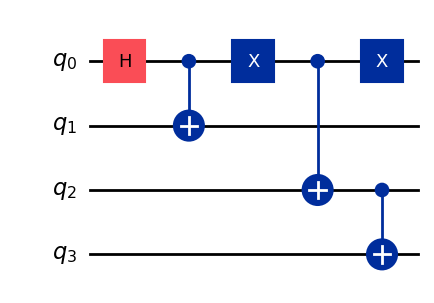

In [3]:
qc_prep = QuantumCircuit(Norb)
qc_prep.h(0)
qc_prep.cx(0,1)
qc_prep.x(0)
qc_prep.cx(0,2)
qc_prep.cx(2,3)
qc_prep.x(0)
qc_prep.draw('mpl')

In [4]:
state_vector = Statevector.from_instruction(qc_prep)
state_vector.draw("latex")

<IPython.core.display.Latex object>

これをユニタリ演算子$U_p$としておく。

In [5]:
Uprep = qc_prep.to_gate()
Uprep.name = "$U_p$"
Updag = Uprep.inverse()

In [6]:
qc_prep = QuantumCircuit(Norb)
qc_prep.append(Uprep, range(Norb))
state_vector = Statevector.from_instruction(qc_prep)
display(state_vector.draw("latex"))

# 逆演算U^{\dagger}_pを作用させて|0>に戻るかチェック
qc_prep.append(Updag, range(Norb))
state_vector = Statevector.from_instruction(qc_prep)
display(state_vector.draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

$U_i \equiv e^{- i H t_i}$と$U_j \equiv e^{-i H t_j}$、これらのcontrolled-Uを用意しておく:

In [7]:
trotter_steps = 1 
Ui = PauliEvolutionGate(hamil_op, t_i, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
Uj = PauliEvolutionGate(hamil_op, t_j, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))

circuit_Ui = QuantumCircuit(Norb)
circuit_Ui.append(Ui, range(Norb))
circuit_Ui.name = '$U(t_i)$'
gate_Ui = circuit_Ui.to_gate()

circuit_Uj = QuantumCircuit(Norb)
circuit_Uj.append(Uj, range(Norb))
circuit_Uj.name = '$U(t_j)$'
gate_Uj = circuit_Uj.to_gate()

# c-Ui: controlled U = exp(-iHt_i)
circuit_cUi = QuantumCircuit(Norb)
circuit_cUi.append(Uprep, range(Norb))
circuit_cUi.append(Ui, range(Norb))
circuit_cUi.name = 'c-$U(t_i) U_p$'
gate_cUi = circuit_cUi.to_gate().control(1)

# C-Uj 
circuit_cUj = QuantumCircuit(Norb)
circuit_cUj.append(Uprep, range(Norb))
circuit_cUj.append(Uj, range(Norb))
circuit_cUj.name = 'c-$U(t_j) U_p$'
gate_cUj = circuit_cUj.to_gate().control(1)


まず $\ket{\Psi_i} = U_i U_p |0\rangle^{\otimes 4}, \ket{\Psi_j} = U_j U_p |0\rangle^{\otimes 4}$を作り、overlapをstatevectorで計算してみよう。

In [8]:
qc_psi_i = QuantumCircuit(Norb)
qc_psi_i.append(Uprep, range(Norb))
qc_psi_i.append(gate_Ui, range(Norb))
psi_i = Statevector.from_instruction(qc_psi_i)

qc_psi_j = QuantumCircuit(Norb)
qc_psi_j.append(Uprep, range(Norb))
qc_psi_j.append(gate_Uj, range(Norb))
psi_j = Statevector.from_instruction(qc_psi_j)

overlap = np.dot(psi_i.data.conj(), psi_j.data)
Re_overlap = np.real(overlap)
Im_overlap = np.imag(overlap)

print("psi_i"); display(psi_i.draw("latex"))
print("psi_j"); display(psi_j.draw("latex"))
print("<psi_i|psi_j>", overlap)
print("cos(t_i-t_j)", np.cos( np.sum(coeff) * (t_i-t_j) ), "sin(t_i-t_j)",  np.sin( np.sum(coeff) * (t_i-t_j) ) )

psi_i


<IPython.core.display.Latex object>

psi_j


<IPython.core.display.Latex object>

<psi_i|psi_j> (0.9985358702188957-0.05409358451972205j)
cos(t_i-t_j) 0.9985358702188959 sin(t_i-t_j) -0.05409358451972206


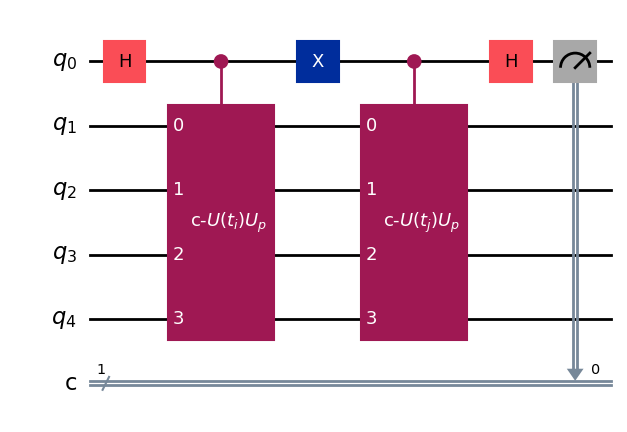

In [9]:
# circuit to measure Re <psi_i|psi_j>
qc_re = QuantumCircuit(1+Norb,1)
qc_re.h(0)
qc_re.append(gate_cUi, ancilla_qubits + target_qubits)
qc_re.x(0)
qc_re.append(gate_cUj, ancilla_qubits+target_qubits)
qc_re.h(0)
qc_re.measure(0,0)
display(qc_re.draw('mpl'))
qc_re = qc_re.decompose()

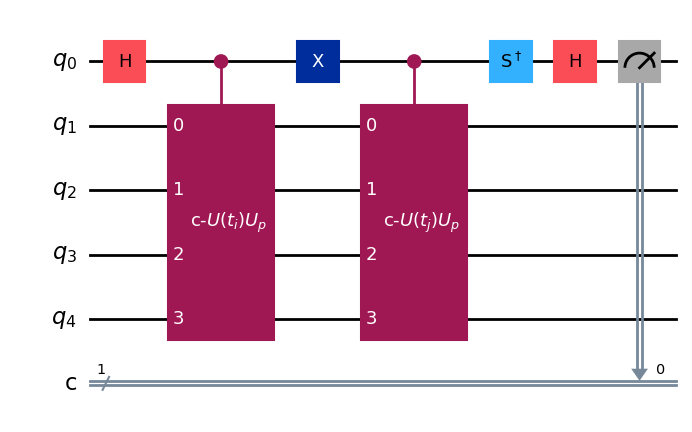

In [10]:
# circuit to measure Im <psi_i|psi_j>
qc_im = QuantumCircuit(1+Norb,1)
qc_im.h(0)
qc_im.append(gate_cUi, ancilla_qubits + target_qubits)
qc_im.x(0)
qc_im.append(gate_cUj, ancilla_qubits+target_qubits)
qc_im.sdg(0)
qc_im.h(0)
qc_im.measure(0,0)
display(qc_im.draw('mpl'))
qc_im = qc_im.decompose()

In [11]:
from qiskit_aer.primitives import SamplerV2
sampler = SamplerV2()
num_shot = 10**5

job = sampler.run([qc_re, qc_im], shots=num_shot)
results  = job.result()

# Real part
prob = results[0].data.c.get_counts()
p0 = prob.get('0',0) / num_shot
p1 = prob.get('1',0) / num_shot
print(f"Estimated Re<psi_i|psi_j> = {p0 - p1:9.5f}  Exact: {Re_overlap:9.5f} Error: {np.abs(p0-p1-Re_overlap):6.2e}")

# Imaginary part
prob = results[1].data.c.get_counts()
p0 = prob.get('0',0) / num_shot
p1 = prob.get('1',0) / num_shot
print(f"Estimated Im<psi_i|psi_j> = {p0 - p1:9.5f}  Exact: {Im_overlap:9.5f} Error: {np.abs(p0-p1-Im_overlap):6.2e}")

Estimated Re<psi_i|psi_j> =   0.99864  Exact:   0.99854 Error: 1.04e-04
Estimated Im<psi_i|psi_j> =  -0.05926  Exact:  -0.05409 Error: 5.17e-03


### $\langle \Psi_a | H | \Psi_b \rangle $の計算

次に、$\langle \Psi_a | H | \Psi_b \rangle$の計算を考える。

対角成分は、状態作成の回路を用いて、$ \langle \hat{H} \rangle = \sum_n \langle \Psi_i | \hat{H}_n | \Psi_i \rangle$を測定すれば良い。
ここで、Hamiltonianの各項は、$\hat{H}_n = G_0 \otimes G_1 \otimes G_2 \otimes \ldots, G \equiv \{I, X, Y, Z\}$と、各パウリ演算子の積で表現してある。

### ハミルトニアンの各項の期待値測定のための回路

`"IIXIXII"`のようなpauli string(的な変数)に対して、必要なbasis rotationを足す関数を作っておこう。
必要な操作は$X$と$Y$の測定のための回路の追加と、そのZ基底での測定である。

XXII


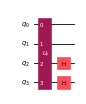

IYIY


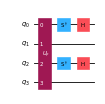

In [12]:
def additional_qc(qc_in, pauli_str, register_target, Qiskit_order=True):
    pauli_str = str(pauli_str)
    if Qiskit_order:
        pauli_str = pauli_str[::-1]

    for i in range(len(pauli_str)):
        if pauli_str[i] == "X":
            qc_in.h(register_target[i])
        elif pauli_str[i] == "Y":
            qc_in.sdg(register_target[i]); qc_in.h(register_target[i])
        elif pauli_str[i] == "Z" or pauli_str[i] == "I":
            pass
        else:
            raise ValueError("Invalid Pauli string: ", pauli_str)

def get_idx_to_measure(pauli_str, Qiskit_order=True):
    idxs = [ idx for idx, p in enumerate(pauli_str) if p != "I"]
    if Qiskit_order:
        idxs = [ len(pauli_str) - 1 - idx for idx in idxs]
    return idxs

hamil = ["XXII", "IYIY"]
for h in hamil:
    idx_relevant = get_idx_to_measure(h)
    print(h) # idx_relevant)
    qc = QuantumCircuit(Norb)
    qc.append(Uprep, range(Norb))
    additional_qc(qc, h, range(Norb))    
    display(qc.draw('mpl', scale=0.3))

既にQiskitの章で作った、pairing Hamiltonianの状態作成回路などを用いて期待値計算が正しく出来ることを確認しておこう。

In [13]:
def ansatz(params, method="FCI"):
    qc = QuantumCircuit(Norb)
    # HF
    for i in range(Nocc):
        qc.x(i)
    # Additional gates
    if method == "FCI":
        if Norb != 4 or Nocc != 2:
            print("You are using parameters to reproduce the FCI wavefunction for Norb=4 and Nocc=2")
            print("Please make sure whether this is correct for your case!")
        qc.append(G_gate(params[0]), [1, 2])
        qc.append(G_gate(params[1]), [2, 3])
        qc.append(cG1_gate(params[2]), [2, 0, 1])
        qc.append(cG1_gate(params[3]), [3, 0, 1])
        qc.append(cG1_gate(params[4]), [3, 1, 2])        
    return qc

In [14]:
Hamil_coeffs = hamiltonian_op.coeffs

idxs_relevant = [ ]
qcs = [ ]
verbose = False
using_statevector = True
for h_term in list(hamiltonian_op.paulis):
    h_term = h_term.to_label()
    idx_relevant = get_idx_to_measure(h_term)
    idxs_relevant.append(idx_relevant)
    qc = ansatz(params_exact)
    additional_qc(qc, h_term, range(Norb))
    if verbose:
        print(h_term, idx_relevant)
        display(qc.draw('mpl', scale=0.5))
    qc = qc.decompose().decompose()
    if not(using_statevector):
        qc.measure_all()
    qcs.append(qc)


if using_statevector:
    results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs]
else:
    job = sampler.run(qcs, shots=num_shot)
    results  = job.result()

Esum = 0.0
for idx in range(len(qcs)):
    h_term = hamiltonian_op.paulis[idx]
    idx_relevant = idxs_relevant[idx]
    if using_statevector:
        res = results[idx]
    else:
        res = results[idx].data.meas.get_counts()

    expval, dummy, dummy_ = expec_Zstring(res, idx_relevant)
    print(h_term.to_label(), Hamil_coeffs[idx], expval)
    Esum += Hamil_coeffs[idx] * expval
print("Esum", Esum, "Egs_exact", Egs_exact)

IIII (5.34+0j) 1.0
IIIZ (0.165+0j) -0.9719921725083537
IIZI (-0.835+0j) -0.9138806897044238
IZII (-1.835+0j) 0.9138801737253328
ZIII (-2.835+0j) 0.9719926884874447
IIXX (-0.165+0j) 0.04821208188098893
YYII (-0.165+0j) 0.04821177091461082
IXIX (-0.165+0j) 0.19420741548699103
YIYI (-0.165+0j) 0.1942049102344519
XIIX (-0.165+0j) 0.13006151287556628
YIIY (-0.165+0j) 0.1300615128755664
IXXI (-0.165+0j) 0.3556794042467488
IYYI (-0.165+0j) 0.3556794042467488
XIXI (-0.165+0j) 0.194204910234452
IYIY (-0.165+0j) 0.1942074154869912
XXII (-0.165+0j) 0.04821177091461088
IIYY (-0.165+0j) 0.048212081880989174
Esum (1.1898518352304355+0j) Egs_exact 1.1898518351360725


無事、期待値を計算するための回路追加(≒basis rotation)と自作関数が正しく動いたことが確認できた。

### 対角成分 $\langle \Psi_a | H | \Psi_a \rangle$ の計算

まず対角成分の計算をする。

Hamiltonianの固有状態にすればエネルギーの推定値が得られるはずで、チェックになる。
加えて、適当な時間発展した状態の場合もあわせて考えよう。その際は時間発展は適当な値にしておく。

In [15]:
state = "exact"
#state = "Uprep"

Hamil_coeffs = hamiltonian_op.coeffs
Hamil_paulis = hamiltonian_op.paulis
qcs = []
verbose = False
using_statevector = True
for idx_H in range(len(Hamil_paulis)):
    op_string = Hamil_paulis[idx_H].to_label()
    idx_relevant = get_idx_to_measure(op_string)
    if state == "exact":
        qc_exact = ansatz(params_exact)
        qc_reH_D = qc_exact.copy()
    elif state == "Uprep":
        qc_reH_D = QuantumCircuit(Norb)
        qc_reH_D.append(Uprep, range(Norb))    
        qc_reH_D.append(gate_Ui, range(Norb))
    additional_qc(qc_reH_D, op_string, range(Norb))
    if verbose:
        print(op_string, Hamil_coeffs[idx_H])
        display(qc_reH_D.draw('mpl', scale=0.3))
    if not(using_statevector):
        qc_reH_D.measure_all()
    qc_reH_D = qc_reH_D.decompose().decompose()
    qcs.append(qc_reH_D)

if using_statevector:
    results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs]
else:
    job = sampler.run(qcs, shots=num_shot)
    results  = job.result()

Hsum = 0.0
for idx_H in range(len(Hamil_paulis)):
    op_string = Hamil_paulis[idx_H].to_label()
    idx_relevant = get_idx_to_measure(op_string)
    if using_statevector:
        res = results[idx_H]
    else:
        res = results[idx_H].data.meas.get_counts()
    expval, dummy, dummy_ = expec_Zstring(res, idx_relevant)
    Hsum += Hamil_coeffs[idx_H] * expval
    print("operator: ", op_string, "coeff: ", Hamil_coeffs[idx_H], "exp. val: ",  expval)

print("using statevector", using_statevector, "Hsum", Hsum)
if state == "exact":
    print("Hsum should be close to Egs_exact", Egs_exact, "diff.", Hsum - Egs_exact)

operator:  IIII coeff:  (5.34+0j) exp. val:  1.0
operator:  IIIZ coeff:  (0.165+0j) exp. val:  -0.9719921725083537
operator:  IIZI coeff:  (-0.835+0j) exp. val:  -0.9138806897044238
operator:  IZII coeff:  (-1.835+0j) exp. val:  0.9138801737253328
operator:  ZIII coeff:  (-2.835+0j) exp. val:  0.9719926884874447
operator:  IIXX coeff:  (-0.165+0j) exp. val:  0.04821208188098893
operator:  YYII coeff:  (-0.165+0j) exp. val:  0.04821177091461082
operator:  IXIX coeff:  (-0.165+0j) exp. val:  0.19420741548699103
operator:  YIYI coeff:  (-0.165+0j) exp. val:  0.1942049102344519
operator:  XIIX coeff:  (-0.165+0j) exp. val:  0.13006151287556628
operator:  YIIY coeff:  (-0.165+0j) exp. val:  0.1300615128755664
operator:  IXXI coeff:  (-0.165+0j) exp. val:  0.3556794042467488
operator:  IYYI coeff:  (-0.165+0j) exp. val:  0.3556794042467488
operator:  XIXI coeff:  (-0.165+0j) exp. val:  0.194204910234452
operator:  IYIY coeff:  (-0.165+0j) exp. val:  0.1942074154869912
operator:  XXII coeff: 

非対角成分については、先ほどのoverlapを計算するための回路の後半の制御ユニタリ(状態作成+時間発展)の後に、Hamiltonianの各パウリ演算子をターゲット量子ビットに対しても測ってやれば良い。

時間発展させると検算が大変なので、適当な状態を二個$\ket{A}, \ket{B}$作って、$\langle A | \hat{H} | B \rangle$を計算してみよう。
$\ket{\psi_i} = \ket{\mathrm{HF}}$, $\ket{\psi_j} = \ket{\mathrm{FCI}}$とすると、
$ H_{ij} = \langle \psi_i | \hat{H} | \psi_j \rangle = E \langle HF | FCI \rangle$となるので検算ができる。

In [16]:
qc = ansatz(params_exact)
gs_state = Statevector.from_instruction(qc)
display(gs_state.draw("latex"))
print("Egs_exact", Egs_exact)

<IPython.core.display.Latex object>

Egs_exact 1.1898518351360725


HFとのoverlapは0.9712...., E=1.1898...なので、$H_{ij} = 1.1556...$となってほしい。
また、`"IIII"`の項は単純にoverlapを計算すればよいので、期待値が0.9712...になることもチェックに使える。

In [17]:
# circuit to measure Re <psi_i|H|psi_j> (non-diagonal part)
using_statevector =True
qcs = []
for idx_H in range(len(Hamil_paulis)):
    op_string = Hamil_paulis[idx_H].to_label()
    qc_reH_nonD = QuantumCircuit(1+Norb)
    qc_reH_nonD.h(0)
    # Controlled-Ui
    gate_HF = ansatz(params_exact, method="HF").control(1)
    gate_HF.name = "HF"
    qc_reH_nonD.append(gate_HF, ancilla_qubits + target_qubits)
    qc_reH_nonD.x(0)
    # Controlled-Uj
    gate_FCI = ansatz(params_exact, method="FCI").control(1)
    gate_FCI.name = "FCI"
    qc_reH_nonD.append(gate_FCI, ancilla_qubits+target_qubits)

    # To measure Real part
    qc_reH_nonD.h(0)
    additional_qc(qc_reH_nonD, op_string, target_qubits)
    if not(using_statevector):
        qc_reH_nonD.measure_all()
    #display(qc_reH_nonD.draw('mpl', scale=0.6))
    qc_reH = qc_reH_nonD.decompose().decompose()
    qcs.append(qc_reH)

if using_statevector:
    results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs]
else:
    num_shot = 10**6
    job = sampler.run(qcs, shots=num_shot)
    results  = job.result()

Re_H_ij = 0.0
for idx_H in range(len(Hamil_paulis)):
    op_string = Hamil_paulis[idx_H].to_label()
    idx_relevant = get_idx_to_measure(op_string)
    if using_statevector:
        res = results[idx_H]
    else:
        res = results[idx_H].data.meas.get_counts()   
    dummy_e, p0, p1 = expec_Zstring(res, idx_relevant, target_qubits=range(len(target_qubits)), ancilla_qubit=0)
    expval = p0 - p1
    Re_H_ij += Hamil_coeffs[idx_H] * expval
    print("operator: ", op_string, "coeff: ", Hamil_coeffs[idx_H], "exp. val: ",  expval)
print("Re H_{ij}", Re_H_ij)

operator:  IIII coeff:  (5.34+0j) exp. val:  0.9712139094394296
operator:  IIIZ coeff:  (0.165+0j) exp. val:  -0.9712139094394293
operator:  IIZI coeff:  (-0.835+0j) exp. val:  -0.9712139094394294
operator:  IZII coeff:  (-1.835+0j) exp. val:  0.9712139094394293
operator:  ZIII coeff:  (-2.835+0j) exp. val:  0.9712139094394294
operator:  IIXX coeff:  (-0.165+0j) exp. val:  -5.204170427930421e-18
operator:  YYII coeff:  (-0.165+0j) exp. val:  -5.204170427930421e-18
operator:  IXIX coeff:  (-0.165+0j) exp. val:  0.09817350815322773
operator:  YIYI coeff:  (-0.165+0j) exp. val:  0.0981721941975748
operator:  XIIX coeff:  (-0.165+0j) exp. val:  0.0636069906573104
operator:  YIIY coeff:  (-0.165+0j) exp. val:  0.06360699065731032
operator:  IXXI coeff:  (-0.165+0j) exp. val:  0.18193913447081592
operator:  IYYI coeff:  (-0.165+0j) exp. val:  0.18193913447081603
operator:  XIXI coeff:  (-0.165+0j) exp. val:  0.09817219419757481
operator:  IYIY coeff:  (-0.165+0j) exp. val:  0.098173508153227

時間発展を考えてない部分的チェックだが、大丈夫そうだ。

## Quantum Krylov法の実装





iterationごとに、$n$回目の状態$\ket{\Psi_n} = \exp(-iHn \delta t ) \ket{\Phi_0}$を作成し、$n-1$回目overlap行列の要素を計算する。

検算のために、固有状態$\ket{\Phi}$の時間発展を考えよう。

$H \ket{\Phi} = E \ket{\Phi}$なので、$e^{-iHt} \ket{\Phi} = e^{-iEt} \ket{\Phi}$から、
$\ket{\psi_0} = \ket{\Phi}, \ket{\psi_1} = e^{-iH\delta t}\ket{\Phi}$とすると、

$$
\begin{align}
N_{01} & \equiv \langle \psi_0 | \psi_1 \rangle  = \bra{\Phi} e^{-i\hat{H}\delta t} \ket{\Phi} = e^{-iE\delta t} \braket{\Phi | \Phi} = e^{-iE\delta t} \nonumber \\
H_{00} & \equiv \langle \psi_0 | \hat{H} | \psi_0 \rangle = E \nonumber \\
H_{01} & \equiv \langle \psi_0 | \hat{H} | \psi_1 \rangle = \bra{\Phi} \hat{H} e^{-i\hat{H}\delta t} \ket{\Phi} = E e^{-iE\delta t} \nonumber
\end{align}
$$

状態作成を厳密解に取ることでこれらの値は、shot errorの範囲内で再現していることがわかる。

以下では、ランダムな試行関数から始めて固有値の推定ができているかをチェックしよう。

In [18]:
def make_U_and_cU(i, delta_t, trotter_steps, hamiltonian_op, ancilla_qubits, target_qubits, Uprep):
    Ntar = len(target_qubits)
    time = i * delta_t
    circuit_U = QuantumCircuit(Ntar)
    expiHt = PauliEvolutionGate(hamiltonian_op, time, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
    circuit_U.append(expiHt, range(Ntar))
    qc_U = circuit_U.decompose().decompose()
    
    qc_cU = QuantumCircuit(Ntar)
    qc_cU.append(Uprep, range(Ntar))
    qc_cU.append(expiHt, range(Ntar))
    qc_cU = qc_cU.decompose().decompose()
    qc_cU = qc_cU.to_gate().control(1)

    return qc_U, qc_cU

def make_overlap_qc(Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, using_statevector):
    qc_re = QuantumCircuit(1+Ntar, 1)
    qc_re.h(0)
    qc_re.append(gate_cUi, ancilla_qubits + target_qubits)
    qc_re.x(0)
    qc_re.append(gate_cUj, ancilla_qubits+target_qubits)
    qc_re.h(0)
    if not using_statevector:
        qc_re.measure(0,0)
    qc_re = qc_re.decompose()

    # Overlap, Im part 
    qc_im = QuantumCircuit(1+Ntar,1)
    qc_im.h(0)
    qc_im.append(gate_cUi, ancilla_qubits + target_qubits)
    qc_im.x(0)
    qc_im.append(gate_cUj, ancilla_qubits + target_qubits)
    qc_im.sdg(0)
    qc_im.h(0)
    if not using_statevector:
        qc_im.measure(0,0)
    qc_im = qc_im.decompose()

    return qc_re, qc_im

def measure_overlap(num_shot, Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, sampler, using_statevector,
                    do_simulation=True):
    qc_re, qc_im = make_overlap_qc(Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, using_statevector)
    if do_simulation:
        if using_statevector:
            results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in [qc_re, qc_im]]
            prob_Re = results[0]
            prob_Im = results[1] 
        else:
            job = sampler.run([qc_re, qc_im], shots=num_shot)
            results  = job.result()
            prob_Re = results[0].data.c.get_counts()
            prob_Im = results[1].data.c.get_counts()

        p0 = np.sum( [ count for bitstr, count in prob_Re.items() if bitstr[-1] == '0' ] ) / np.sum(list(prob_Re.values()))
        p1 = np.sum( [ count for bitstr, count in prob_Re.items() if bitstr[-1] == '1' ] ) / np.sum(list(prob_Re.values()))
        ReN = p0 - p1

        p0 = np.sum( [ count for bitstr, count in prob_Im.items() if bitstr[-1] == '0' ] ) / np.sum(list(prob_Im.values()))
        p1 = np.sum( [ count for bitstr, count in prob_Im.items() if bitstr[-1] == '1' ] ) / np.sum(list(prob_Im.values()))
        ImN = p0 - p1

        U_ij = ReN + 1j * ImN
        return U_ij
    else: #only resource estimation
        print("qc_re:", dict(qc_re.count_ops()))
        print("qc_im:", dict(qc_im.count_ops()))
        return None

def make_cU(Uprep, Ui, Ntar):
    circuit_cUi = QuantumCircuit(Ntar)
    circuit_cUi.append(Uprep, range(Ntar))
    circuit_cUi.append(Ui, range(Ntar))
    circuit_cUi = circuit_cUi.decompose().decompose()
    return circuit_cUi.to_gate().control(1)

def make_nonD_H_qc(op_string, Ntar, ancilla_qubits, target_qubits, gate_cUi, gate_cUj, qcs_re, qcs_im, using_statevector):
    # real part
    qc_reH_nonD = QuantumCircuit(1+Ntar)
    qc_reH_nonD.h(0)
    qc_reH_nonD.append(gate_cUi, ancilla_qubits + target_qubits)
    qc_reH_nonD.x(0)
    qc_reH_nonD.append(gate_cUj, ancilla_qubits + target_qubits)
    qc_reH_nonD.h(0)
    additional_qc(qc_reH_nonD, op_string, target_qubits)
    if not using_statevector:
        qc_reH_nonD.measure_all()
    qc_reH = qc_reH_nonD.decompose().decompose()
    qcs_re.append(qc_reH)

    # imaginary part
    qc_imH_nonD = QuantumCircuit(1+Ntar)
    qc_imH_nonD.h(0)
    qc_imH_nonD.append(gate_cUi, ancilla_qubits + target_qubits)
    qc_imH_nonD.x(0)
    qc_imH_nonD.append(gate_cUj, ancilla_qubits + target_qubits)
    qc_imH_nonD.sdg(0)
    qc_imH_nonD.h(0)
    additional_qc(qc_imH_nonD, op_string, target_qubits)
    if not using_statevector:
        qc_imH_nonD.measure_all()
    qc_imH = qc_imH_nonD.decompose().decompose()
    qcs_im.append(qc_imH)

    return None

def plot_convergence(ws, evals):
    cols = sns.color_palette("deep", n_colors=len(evals))
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(1, 1, 1)
    for it in range(len(ws)):
        x = it + 1
        for n in range(len(ws[it])):
            y = ws[it][n]
            ax.scatter(x, y, marker="D", color=cols[n])
    for n in range(len(evals)):
        ax.axhline(y=evals[n], color='gray', linestyle='dotted')
    ax.set_xlabel("iteration")
    ax.set_ylabel("overlap")
    ax.set_ylim(0, np.max(evals)*1.05)
    #plt.show()
    if using_statevector:
        fig.savefig("QKrylov_Norb"+str(Norb)+"Nocc"+str(Nocc)+"_statevector.pdf")
    else:
        fig.savefig("QKrylov_Norb"+str(Norb)+"Nocc"+str(Nocc)+"_shot.pdf")
    plt.close()

def QuantumKrylov(Uprep: QuantumCircuit, # circuit to prepare a reference state
                 hamiltonian_op: SparsePauliOp, # Hamiltonian operator
                 sampler,
                 delta_t=0.01,
                 max_iterations=10,
                 trotter_steps=1, 
                 num_shot=10**4, 
                 ancilla_qubits=[], target_qubits=[],
                 using_statevector=False,
                 do_simulation=True,
                 ):
    Ntar = len(target_qubits)
    N = np.zeros((max_iterations, max_iterations), dtype=np.complex128)
    H = np.zeros((max_iterations, max_iterations), dtype=np.complex128)
    ws = []
    Unitaries = [ ]
    if True:
        Ui = PauliEvolutionGate(hamiltonian_op, delta_t, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
        gate_cUi = make_cU(Uprep, Ui, Ntar)
        Uj = PauliEvolutionGate(hamiltonian_op, 2*delta_t, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
        gate_cUj = make_cU(Uprep, Uj, Ntar)

        qc_Ui = QuantumCircuit(1+Ntar)
        qc_Ui.append(gate_cUi, range(Ntar+1))
        qc_Ui = qc_Ui.decompose(reps=5)
        print("Circuit for c-UiUp:", dict(qc_Ui.count_ops()))
        U_ij = measure_overlap(num_shot, Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, sampler, using_statevector, do_simulation)
        num_of_Hamil_term = len(hamiltonian_op.paulis)
        print("num of Hamil term: ", num_of_Hamil_term)
    if not(do_simulation):
        return None
    
    for it in range(max_iterations):
        print("iteration: ", it)
        ## make controlled U = exp(-iHδt * it)
        Ui = PauliEvolutionGate(hamiltonian_op, it*delta_t, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
        gate_cUi = make_cU(Uprep, Ui, Ntar)
        Unitaries.append(gate_cUi)
        N[it, it] = 1.0
        ## evaluate overlap to previous states
        for j in range(it-1, -1, -1):
            gate_cUj = Unitaries[j]
            U_ij = measure_overlap(num_shot, Ntar, gate_cUi, gate_cUj, ancilla_qubits, target_qubits, sampler, using_statevector, do_simulation)
            N[it, j] = U_ij
            N[j, it] = np.conj(U_ij)
        ### evaluate H_ii no need ancilla qubit
        qcs = []  
        for idx_H in range(len(Hamil_paulis)):
            op_string = Hamil_paulis[idx_H].to_label()
            idx_relevant = get_idx_to_measure(op_string)
            qc_reH_D = QuantumCircuit(Ntar)
            qc_reH_D.append(Uprep, range(Ntar))
            qc_reH_D.append(Ui, range(Ntar))
            additional_qc(qc_reH_D, op_string, range(Ntar))
            if not(using_statevector):
                qc_reH_D.measure_all()
            qc_reH_D = qc_reH_D.decompose().decompose()
            qcs.append(qc_reH_D)
        if using_statevector:
            results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs]
        else:
            job = sampler.run(qcs, shots=num_shot)
            results  = job.result()

        Hsum = 0.0
        for idx_H in range(len(Hamil_paulis)):
            op_string = Hamil_paulis[idx_H].to_label()
            idx_relevant = get_idx_to_measure(op_string)
            if using_statevector:
                res = results[idx_H]
            else:
                res = results[idx_H].data.meas.get_counts()
            expval, dummy, dummy_ = expec_Zstring(res, idx_relevant)
            Hsum += Hamil_coeffs[idx_H] * expval
            ##print("operator: ", op_string, "coeff: ", Hamil_coeffs[idx_H], "exp. val: ",  expval)
        #print("H[it, it]", it, Hsum)
        H[it, it] = Hsum

        ### evaluate H_ij ancilla qubit is needed
        for j in range(it-1, -1, -1):
            gate_cUj = Unitaries[j]
            qcs_re = []
            qcs_im = []
            for idx_H in range(len(Hamil_paulis)):
                op_string = Hamil_paulis[idx_H].to_label()
                make_nonD_H_qc(op_string, Ntar, ancilla_qubits, target_qubits, gate_cUi, gate_cUj, qcs_re, qcs_im, using_statevector)
            # Re part
            if using_statevector:
                results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs_re]
            else:
                job = sampler.run(qcs_re, shots=num_shot)
                results  = job.result()
            Re_H_ij = 0.0
            for idx_H in range(len(Hamil_paulis)):
                op_string = Hamil_paulis[idx_H].to_label()
                idx_relevant = get_idx_to_measure(op_string)
                if using_statevector:
                    res = results[idx_H]
                else:
                    res = results[idx_H].data.meas.get_counts()
                dummy_e, p0, p1 = expec_Zstring(res, idx_relevant, target_qubits=range(len(target_qubits)), ancilla_qubit=0)
                expval = p0 - p1
                Re_H_ij += Hamil_coeffs[idx_H] * expval
                #print("operator: ", op_string, "coeff: ", Hamil_coeffs[idx_H], "exp. val: ",  expval)
            #print("Re H_{ij}", Re_H_ij)

            # Im part
            if using_statevector:
                results = [ Statevector.from_instruction(qc).probabilities_dict() for qc in qcs_im]
            else:
                job = sampler.run(qcs_im, shots=num_shot)
                results  = job.result() 
            Im_H_ij = 0.0
            for idx_H in range(len(Hamil_paulis)):
                op_string = Hamil_paulis[idx_H].to_label()
                idx_relevant = get_idx_to_measure(op_string)
                if using_statevector:
                    res = results[idx_H]
                else:
                    res = results[idx_H].data.meas.get_counts()   
                dummy_e, p0, p1 = expec_Zstring(res, idx_relevant, target_qubits=range(len(target_qubits)), ancilla_qubit=0)
                expval = p0 - p1
                Im_H_ij += Hamil_coeffs[idx_H] * expval
            #print("Im H_{ij}", Im_H_ij)

            H[it, j] = Re_H_ij + 1j * Im_H_ij
            H[j, it] = Re_H_ij - 1j * Im_H_ij

        # solve generalized eigenvalue problem
        Nsub = N[:it+1, :it+1]
        Hsub = H[:it+1, :it+1]        
        lam, v = scipy.linalg.eigh(Nsub) 
        # truncate orthogonal basis with small eigenvalues
        cols = [ i for i in range(it+1) if lam[i] >= 1.e-6]
        r = len(cols)
        Ur = v[:,cols]
        sq_Sigma_inv = np.diag(lam[cols]**(-0.5))

        X = Ur @ sq_Sigma_inv @ Ur.conj().T
        Xdag = X.conj().T
        tildeH = X @ Hsub @ Xdag
        w, v = scipy.linalg.eigh(tildeH)
        
        w_r = w[-r:]
        ws += [w_r]

        print("eigs of N: ", lam, "cond", np.linalg.cond(Nsub), "r:", r)
        print(f"w: {w_r}")
        print("")
    return H[:it+1,:it+1], N[:it+1,:it+1], ws

initial = "exact"
initial = ""

if initial == "exact":
    Uprep = ansatz(params_exact) # exact ground state
else:
    np.random.seed(0)
    params_random = np.random.rand(5)
    Uprep = ansatz(params_random) # random state

Hamil_coeffs = hamiltonian_op.coeffs
Hamil_paulis = hamiltonian_op.paulis
dt = 1.0

using_statevector = True
#using_statevector = False
Hmat, Nmat, Ens = QuantumKrylov(Uprep, hamiltonian_op, sampler, delta_t=dt, max_iterations=min([10,len(evecs)]), trotter_steps=20, 
                           num_shot=10**4, 
                           ancilla_qubits=[0], target_qubits=list(range(1,Norb+1)),
                           using_statevector=using_statevector)
print("Eexact", evals)
plot_convergence(Ens, evals)

if initial == "exact":
    print("<Ψ0|Ψ1>", np.exp(- 1j * Egs_exact * dt) , "N[0,1]", Nmat[0,1])
    print("<Ψ0|H|Ψ0>", Egs_exact, "H[0,0]", Hmat[0,0])
    print("<Ψ0|H|Ψ1>", np.exp(- 1j * Egs_exact * dt) * Egs_exact, "H[0,1]", Hmat[0,1])
    print("<Ψ0|Ψ2>", np.exp(- 1j * Egs_exact * dt * 2), "N[0,2]", Nmat[0,2])
    print("<Ψ0|H|Ψ2>", np.exp(- 1j * Egs_exact * dt * 2) * Egs_exact, "H[0,2]", Hmat[0,2])

Circuit for c-UiUp: {'u': 11185, 'cx': 6280}
num of Hamil term:  17
iteration:  0
eigs of N:  [1.] cond 1.0 r: 1
w: [1.61127485]

iteration:  1
eigs of N:  [0.2458579 1.7541421] cond 7.134780216944254 r: 2
w: [1.27321303 3.35359765]

iteration:  2
eigs of N:  [0.00826746 0.49858876 2.49314379] cond 301.5611013988385 r: 3
w: [1.24902173 3.31208999 5.35070515]

iteration:  3
eigs of N:  [1.29344560e-04 9.94465747e-03 6.17854557e-01 3.37207144e+00] cond 26070.45439089142 r: 4
w: [1.21235523 3.30438719 5.34426495 8.04823827]

iteration:  4
eigs of N:  [3.43778353e-05 2.59020054e-04 1.82356214e-02 8.07696117e-01
 4.17377486e+00] cond 121408.89122291954 r: 5
w: [1.20356938 3.3003931  5.34       6.28446185 8.23399773]

iteration:  5
eigs of N:  [1.65876983e-05 1.25943366e-04 4.91424981e-04 2.29889501e-02
 9.95820982e-01 4.98055611e+00] cond 300256.0107413335 r: 6
w: [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758]

Eexact [1.18985184 3.29649666 5.34       5.34       7.42853

$N_\mathrm{orb}=4, N_\mathrm{occ}=2$の場合は次元が6なので、iterationが6になった時点で理想的には厳密解と一致するはずである。
ちなみに、3番目の状態は縮退しているので、緑と赤のシンボルが近づいていくのは誤りではない。

![](pic/QKrylov_Norb4Nocc2_statevector.png)

もう少しサイズの大きな$N_\mathrm{orb}=6, N_\mathrm{occ}=2$の場合の結果(次元=15)も示しておく。

![](pic/QKrylov_Norb6Nocc2_statevector.png)

statevectorを用いた場合は上のように、厳密解へと収束する様子が見て取れるが、
shotで測る場合は、ノイズなしのsimulator(shot errorのみ)でも、$H,N$の精度により疑似固有値が得られてしまう。
$N_\mathrm{orb}=4, N_\mathrm{occ}=2$で、$10^4$ shotで計算した結果を示しておく。

![](pic/QKrylov_Norb4Nocc2_shot.png)

今の実装では、overlapを対角化し小さな固有値を捨てることで、一般化固有値問題をより安定的に解いているものの、それでもshot測定の場合は反復に対して計算が不安定になってしまう。実機のノイズがあると、overlapやHが悪条件になり計算がさらに不安定になることが予想されるため、応用の上ではさらなる検討が必要であろう。

## 関連する話題

multi-referenceによるQuantum Krylov法は、[J. Chem. Theory Comput. 2020, 16, 2326](https://doi.org/10.1021/acs.jctc.9b01125)が参考になる。
overlap行列の計算については、Hadamard test以外にも、上で述べた方法など制御ユニタリを必要としない方法も提案されていて、様々な進展があるようだ。

また、回路等を工夫してIBM実機を用いてKrylov diagonalizationを達成した近年の発展なども非常に興味深い。[N. Yoshioka et al., Nature Comm. 16, 5014 (2025)](https://www.nature.com/articles/s41467-025-59716-z)